<a href="https://colab.research.google.com/github/aruaru0/bert-regression-test/blob/main/HuggingFace_BERT_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transformerのインストールなど

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install git+https://github.com/huggingface/accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-2ufta5y1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-2ufta5y1
  Resolved https://github.com/huggingface/accelerate to commit 4a1d5b

In [2]:
!pip install fugashi
!pip install ipadic
!pip install unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556703 sha256=07679ad6badfc3b9cef6f83a94ec16c16b7780d762cef05f62718cb813df592e
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658816 sha256=12c4fb6c9705b46a947c38ed0ce3756fe49e757a6721911cb91dc6674793f795
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


# データセットを準備

In [3]:
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "ja")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Tokenizerの取得

In [4]:
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-large-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# データサイズを減らす

In [5]:
SEED = 42
TRAIN_SIZE = 2000
TEST_SIZE = 1000

dataset["train"] = dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SIZE))
dataset["validation"] = dataset["validation"].shuffle(seed=SEED).select(range(TEST_SIZE))
dataset["test"] = dataset["test"].shuffle(seed=SEED).select(range(TEST_SIZE))

# データセットの加工

In [6]:
import torch

MAX = 512

def tokenize(batch):
    enc =  tokenizer(batch["review_body"], padding=True, truncation=True, max_length=MAX)
    targets = float(batch['stars']-1)
    enc.update({'labels': targets})
    return enc

In [7]:
dataset_encoded = dataset.map(tokenize)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
small_train_dataset = dataset_encoded['train']
small_valid_dataset = dataset_encoded['validation']
small_test_dataset = dataset_encoded['test']

# 学習


In [9]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 1

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-large-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics import accuracy_score, f1_score
import evaluate
import numpy as np
metric = evaluate.load("mse")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return metric.compute(predictions=predictions, references=labels)

In [11]:
from transformers import TrainingArguments

batch_size = 4
logging_steps = len(small_train_dataset) // batch_size
model_name = "amazon-review-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_train_dataset,
    eval_dataset=small_valid_dataset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Mse
1,1.095900,0.798436,0.798436
2,0.484600,0.853442,0.853442
3,0.245300,0.795478,0.795478


TrainOutput(global_step=1500, training_loss=0.6086011250813802, metrics={'train_runtime': 813.1031, 'train_samples_per_second': 7.379, 'train_steps_per_second': 1.845, 'total_flos': 1397251621144512.0, 'train_loss': 0.6086011250813802, 'epoch': 3.0})

# テストデータに対する結果を評価


In [13]:
preds_output = trainer.predict(small_test_dataset)

In [14]:
x = [[] for _ in range(5)]
cnt = 0
for p, l in zip(preds_output.predictions, preds_output.label_ids) :
  x[int(l)].append(p[0]+1)
  if cnt == 100 : break
  cnt += 1

for i in range(5):
  v = np.array(x[i])
  print(f"{i+1}: mean={v.mean()}, std = {v.std()}")

1: mean=1.6045078789194425, std = 0.5793694766318036
2: mean=2.5612596910446883, std = 1.0326914930118538
3: mean=2.990039425236838, std = 0.8421608195126832
4: mean=3.9735598130659624, std = 0.8356944439024795
5: mean=4.627683509951052, std = 0.5801716356420844


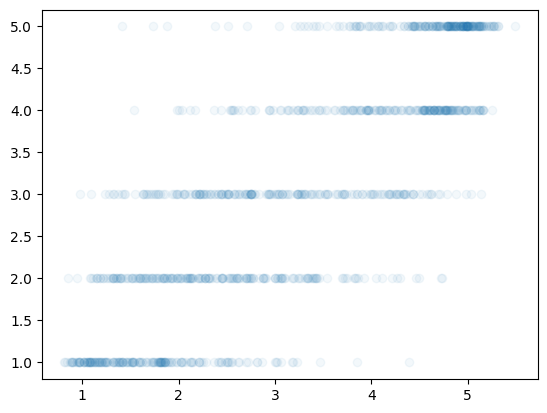

In [15]:
import matplotlib.pyplot as plt

plt.scatter(preds_output.predictions+1, preds_output.label_ids+1, alpha=0.05)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1a81340be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1a81341120>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1a81340940>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1a81341660>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1a81341900>,
 'means': []}

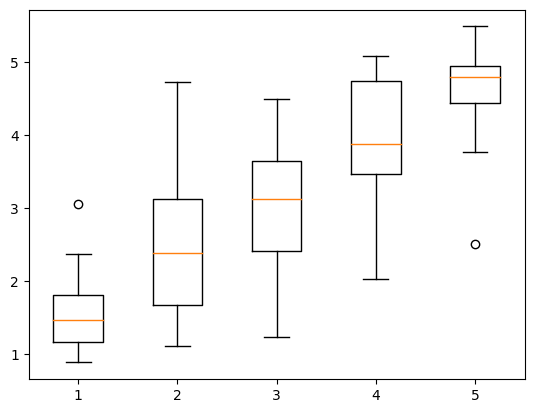

In [16]:
plt.boxplot(x)

# モデルの保存、読み込み

In [17]:
trainer.save_model(f"./{model_name}-test")

In [18]:
tokenizer = AutoTokenizer\
    .from_pretrained(f"./{model_name}-test")

model = (AutoModelForSequenceClassification
    .from_pretrained(f"./{model_name}-test")
    .to(device))